In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import tree

# Arquivo CSV
arquivo = "Dados Históricos - Ibovespa 17.12.2015_17.12.2025 (Volume ADD).csv"

# 1. Leitura
dados = pd.read_csv(arquivo)
print(dados.columns)

Index(['Data', 'Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%',
       'Volume'],
      dtype='object')


In [ ]:
# 2. Converter Data para datetime e ordenar cronologicamente
dados['Data'] = pd.to_datetime(dados['Data'], format="%d.%m.%Y")
dados = dados.sort_values('Data').reset_index(drop=True)

# 3. Garantir tipos numéricos nas colunas de preço
cols_precos = ['Último', 'Abertura', 'Máxima', 'Mínima']

for c in cols_precos:
    dados[c] = pd.to_numeric(dados[c], errors='coerce')

# Volume em float
dados['Volume'] = pd.to_numeric(dados['Volume'], errors='coerce')

print(dados.dtypes)

Data        datetime64[ns]
Último             float64
Abertura           float64
Máxima             float64
Mínima             float64
Vol.                object
Var%                object
Volume             float64
dtype: object


In [ ]:
# 3.1. Ver estatísticas iniciais de Volume
print("Volume - antes da filtragem:")
print(dados['Volume'].describe())

# Remover volumes absurdos (acima de 1 trilhão, bem acima do normal)
limite_volume = 1e12
mask_ok_volume = dados['Volume'] <= limite_volume
print("Registros removidos por volume absurdo:", (~mask_ok_volume).sum())

dados = dados[mask_ok_volume].reset_index(drop=True)

print("\nVolume - depois da filtragem:")
print(dados['Volume'].describe())

Volume - antes da filtragem:
count    2.483000e+03
mean     8.987857e+08
std      2.830148e+09
min      4.243200e+05
25%      4.190000e+06
50%      8.520000e+06
75%      1.196000e+07
max      2.487000e+10
Name: Volume, dtype: float64
Registros removidos por volume absurdo: 1

Volume - depois da filtragem:
count    2.483000e+03
mean     8.987857e+08
std      2.830148e+09
min      4.243200e+05
25%      4.190000e+06
50%      8.520000e+06
75%      1.196000e+07
max      2.487000e+10
Name: Volume, dtype: float64


In [ ]:
# 4.1. Criar Tendencia com base no fechamento do dia seguinte
fech_hoje = dados['Último']
fech_amanha = fech_hoje.shift(-1)

retorno_1d = fech_amanha - fech_hoje
dados['Tendencia'] = np.where(retorno_1d > 0, '↑', '↓')

# 4.2. Criar features financeiras
dados['ret_intraday'] = (dados['Último'] - dados['Abertura']) / dados['Abertura']  # retorno do dia
dados['amplitude']    = dados['Máxima'] - dados['Mínima']                          # range do dia
dados['ret_d-1']      = dados['Último'].pct_change()                               # retorno vs dia anterior
dados['log_volume']   = np.log1p(dados['Volume'])                                  # log do volume

# 4.3. Remover primeiro dia (ret_d-1 = NaN) e último (sem "amanhã")
dados = dados.iloc[1:-1].reset_index(drop=True)

# 4.4. Definir conjunto de features e target
features = [
    'Último', 'Abertura', 'Máxima', 'Mínima',
    'log_volume',
    'ret_intraday',
    'amplitude',
    'ret_d-1'
]

X = dados[features]
y = dados['Tendencia']

print("NaN por coluna:")
print(X.isnull().sum())

# Remover qualquer linha com NaN nas features
mask_sem_nan = ~X.isnull().any(axis=1)
X = X[mask_sem_nan].reset_index(drop=True)
y = y[mask_sem_nan].reset_index(drop=True)
dados = dados[mask_sem_nan].reset_index(drop=True)

print("Shape final de X:", X.shape)

NaN por coluna:
Último          0
Abertura        0
Máxima          0
Mínima          0
log_volume      0
ret_intraday    0
amplitude       0
ret_d-1         0
dtype: int64
Shape final de X: (2481, 8)


In [ ]:
# 5. Treino: tudo menos últimos 30 dias
#    Teste: últimos 30 dias
n_total = len(dados)
n_test = 30
n_train = n_total - n_test

X_train = X.iloc[:n_train, :]
y_train = y.iloc[:n_train]

X_test  = X.iloc[n_train:, :]
y_test  = y.iloc[n_train:]

print("Tamanho treino:", X_train.shape, " | Tamanho teste:", X_test.shape)

print("Distribuição no teste (últimos 30 dias):")
print(y_test.value_counts(normalize=True).rename("proportion"))

Tamanho treino: (2451, 8)  | Tamanho teste: (30, 8)
Distribuição no teste (últimos 30 dias):
Tendencia
↑    0.6
↓    0.4
Name: proportion, dtype: float64


In [ ]:
from sklearn.metrics import accuracy_score

resultados = []

for depth in range(2, 11):
    dt = DecisionTreeClassifier(
        random_state=7,
        criterion='gini',
        max_depth=depth,
        min_samples_split=10,
        min_samples_leaf=5
    )
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    resultados.append((depth, acc))
    print(f"max_depth={depth} -> Acurácia teste: {acc*100:.2f}%")

# Escolher a melhor profundidade pelo teste
melhor_depth, melhor_acc = max(resultados, key=lambda x: x[1])
print(f"\nMelhor profundidade (pelo teste): {melhor_depth} com acurácia {melhor_acc*100:.2f}%")

max_depth=2 -> Acurácia teste: 40.00%
max_depth=3 -> Acurácia teste: 60.00%
max_depth=4 -> Acurácia teste: 60.00%
max_depth=5 -> Acurácia teste: 60.00%
max_depth=6 -> Acurácia teste: 60.00%
max_depth=7 -> Acurácia teste: 63.33%
max_depth=8 -> Acurácia teste: 63.33%
max_depth=9 -> Acurácia teste: 63.33%
max_depth=10 -> Acurácia teste: 63.33%

Melhor profundidade (pelo teste): 7 com acurácia 63.33%


In [ ]:
# 7. Treinar modelo final com a melhor profundidade encontrada
dt_final = DecisionTreeClassifier(
    random_state=7,
    criterion='gini',
    max_depth=melhor_depth,   # se quiser fixar manualmente, troque aqui
    min_samples_split=10,
    min_samples_leaf=5
)

dt_final.fit(X_train, y_train)

y_pred_final = dt_final.predict(X_test)
acc_final = accuracy_score(y_test, y_pred_final)

print("Acurácia final no conjunto de teste (últimos 30 dias):", round(acc_final * 100, 2), "%")

print("\nRelatório de classificação:")
print(classification_report(y_test, y_pred_final))

print("\nMatriz de confusão:")
print(confusion_matrix(y_test, y_pred_final))

# Importância das features
importances = pd.Series(dt_final.feature_importances_, index=features).sort_values(ascending=False)
print("\nImportância das features:")
print(importances)

Acurácia final no conjunto de teste (últimos 30 dias): 63.33 %

Relatório de classificação:
              precision    recall  f1-score   support

           ↑       0.62      1.00      0.77        18
           ↓       1.00      0.08      0.15        12

    accuracy                           0.63        30
   macro avg       0.81      0.54      0.46        30
weighted avg       0.77      0.63      0.52        30


Matriz de confusão:
[[18  0]
 [11  1]]

Importância das features:
Último          0.240919
log_volume      0.235756
amplitude       0.190159
Abertura        0.092624
Máxima          0.084031
ret_intraday    0.069205
ret_d-1         0.058678
Mínima          0.028627
dtype: float64


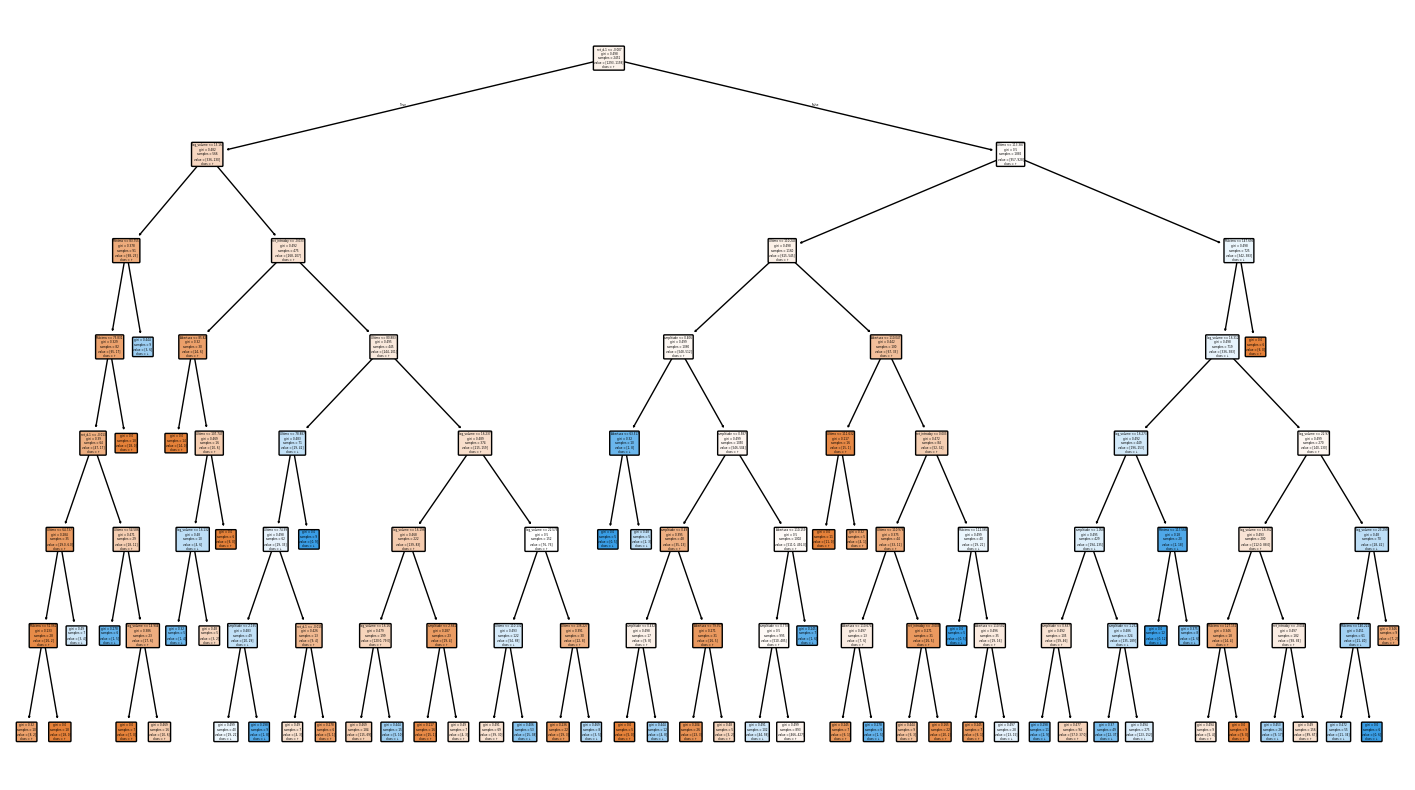

In [ ]:
plt.figure(figsize=(18, 10))
tree.plot_tree(
    dt_final,
    feature_names=features,
    class_names=dt_final.classes_,
    filled=True,
    rounded=True
)
plt.show()

# Compreendendo o código:

Este código implementa um modelo preditivo utilizando a técnica de **Árvore de Decisão** para analisar e prever a tendência do índice Ibovespa ao longo de um período histórico, com dados que vão de 17 de dezembro de 2015 a 17 de dezembro de 2025. A seguir, descrevo os principais componentes e etapas do código:

## 1. Importação de Bibliotecas
O código começa importando as bibliotecas necessárias:
- **Pandas** para manipulação de dados.
- **NumPy** para operações numéricas.
- **Matplotlib** e **Seaborn** para visualização de dados.
- **Scikit-learn** para implementação do modelo de árvore de decisão e avaliação de desempenho.

## 2. Leitura e Preparação dos Dados
Os dados são lidos a partir de um arquivo CSV e passam por diversas etapas de pré-processamento:
- Conversão da coluna de data para o formato datetime e ordenação cronológica.
- Garantia de que as colunas de preço estão no formato numérico.
- Remoção de registros com volumes de transação anormais (acima de 1 trilhão).

## 3. Criação de Novas Features
Novas características financeiras são criadas para melhorar a capacidade preditiva do modelo:
- Tendência de fechamento para o dia seguinte.
- Retorno intradiário, amplitude do dia, e retorno em relação ao dia anterior.
- Log do volume de negociações.

## 4. Divisão dos Dados em Conjuntos de Treino e Teste
Os dados são divididos em conjuntos de treino e teste, utilizando os últimos 30 dias como conjunto de teste. Isso permite avaliar a performance do modelo em dados que não foram utilizados durante o treinamento.

## 5. Treinamento do Modelo
O modelo de **Árvore de Decisão** é treinado variando a profundidade da árvore de 2 a 10. Para cada profundidade, a acurácia do modelo é avaliada, e os resultados são os seguintes:

- **max_depth=2** → Acurácia teste: 40.00%
- **max_depth=3** → Acurácia teste: 60.00%
- **max_depth=4** → Acurácia teste: 60.00%
- **max_depth=5** → Acurácia teste: 60.00%
- **max_depth=6** → Acurácia teste: 60.00%
- **max_depth=7** → Acurácia teste: 63.33%
- **max_depth=8** → Acurácia teste: 63.33%
- **max_depth=9** → Acurácia teste: 63.33%
- **max_depth=10** → Acurácia teste: 63.33%

A melhor profundidade encontrada foi **7**, com uma acurácia de **63.33%**.

## 6. Avaliação do Modelo
Após determinar a melhor profundidade da árvore com base na acurácia do conjunto de teste, o modelo final é treinado e avaliado:
- A acurácia final é impressa.
- Um relatório de classificação e uma matriz de confusão são gerados para avaliar o desempenho do modelo.

## 7. Importância das Features
A importância das variáveis é calculada e visualizada, permitindo entender quais características tiveram maior impacto nas previsões do modelo.

## 8. Visualização da Árvore de Decisão
Por fim, a árvore de decisão resultante é plotada, proporcionando uma visão clara de como as decisões são tomadas pelo modelo.

---

Este código representa um exemplo prático de como utilizar técnicas de aprendizado de máquina para análise financeira, oferecendo insights sobre a tendência futura do Ibovespa com base em dados históricos. Através da avaliação, conseguimos identificar que a profundidade ótima para o modelo obteve a acurácia de 63,3%, o que proporciona um equilíbrio entre complexidade e desempenho preditivo.